In [5]:
import numpy as np
from sklearn.datasets import make_swiss_roll as swiss
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.sparse.csgraph import floyd_warshall

# Data Visualization

In [6]:
X, t = swiss(n_samples=800, random_state=1234)
X = StandardScaler().fit_transform(X)
X.std(axis=0)

array([1., 1., 1.])

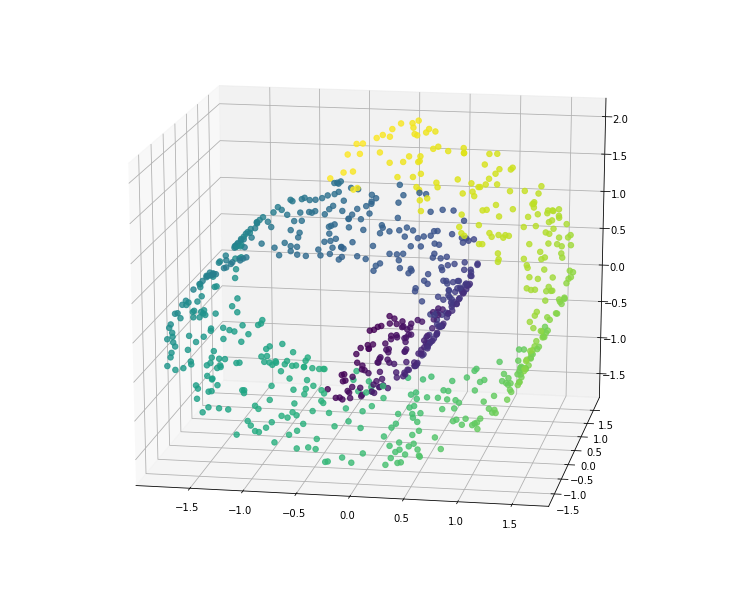

In [7]:
fig = plt.figure(figsize=(10, 8))
ax = Axes3D(fig)
ax.scatter(X[:,0], X[:,1], X[:,2], s=30, c=t, cmap='viridis', alpha=0.8);
ax.view_init(17,-80)

In [8]:
t.shape

(800,)

# PCA

Set mean to 0 and normalize the variance
Then perform PCA with two principal components

In [9]:
X_norm = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_norm)
X_norm.std(axis=0), X_norm.mean(axis=0)

(array([1., 1., 1.]),
 array([ 8.88178420e-18, -2.22044605e-17, -1.77635684e-17]))

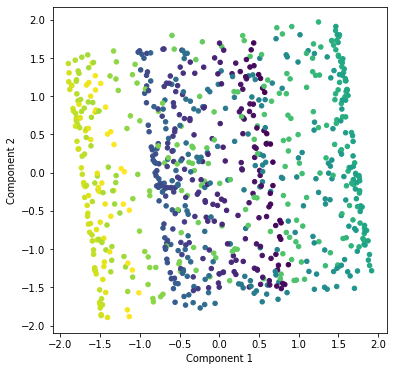

In [10]:
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111) 
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.scatter(principal_components[:,0], principal_components[:,1], s=20, c=t);

We found a manifold which looks like a compressed, 'stepped on' version on our originaly plotted Dataset.

# ISOMAP

In [11]:
def calculate_distance(X):
    D = []
    for i in range(len(X)):
        D_i = []
        for j in range(0, len(X)):
            D_i.append(np.linalg.norm(X[i] - X[j]))
        D.append(D_i)
    return np.array(D)

In [12]:
def neighbhor_k(D, k):
    W = np.copy(D)
    S = np.partition(D, k, axis=1)[:,k].reshape(-1, 1) # calculate k'th biggest value for each row 
    W[D > S] = np.inf
    assert W.all() == W.T.all() # check for symmetry
    return W

In [13]:
def neighbhor_e(D, e):
    W = np.copy(D)
    W[D > e] = np.inf
    return W #symmetric by definition

Since the pseudo-code from the slides doesn't finish in a reasonable time on my machine due to O(n^3)  I use the library function for floyd_warshall

In [14]:
def MDS(D, W):
    H = np.identity(len(D)) - np.ones(len(D)).reshape(-1, 1) @ np.ones(len(D)).reshape(1, -1) / len(D)
    G = -1/2 * H @ floyd_warshall(W) ** 2 @ H
    eigenvalues, V = np.linalg.eigh(G.T)
    EV = np.diag(np.abs(eigenvalues))
    return np.real(EV ** (1/2) @ V.T)

In [22]:
def Isomap_k(X, k):
    D = calculate_distance(X)y
    W = neighbhor_k(D, k)
    return MDS(D, W)

In [23]:
def Isomap_e(X, e):
    D = calculate_distance(X)
    W = neighbhor_e(D, e)
    return MDS(D, W)

In [17]:
Data, t = swiss(n_samples=800, random_state=1234)

In [18]:
k = 8
epsilon = 0.8819

I decided for this epsilon because this clearly seperates the groups, without overlapping.  The same holds true for k too. If epsilon is incremented by 0.0001 or k by 1 the plot changes and we see that the groups purple and turquoise are also not as far away from each other as we think. This would be useful if we would ie. try to connect different user groups in a database.

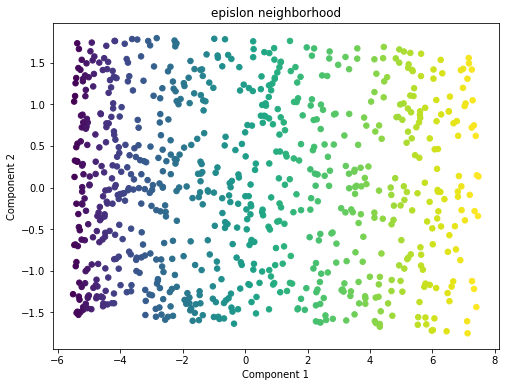

In [19]:
X = np.copy(Data)
X = StandardScaler().fit_transform(X)
X = Isomap_e(X, epsilon)
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_title("epislon neighborhood")
ax.scatter(X[-1], X[-2], s=30, c=t);

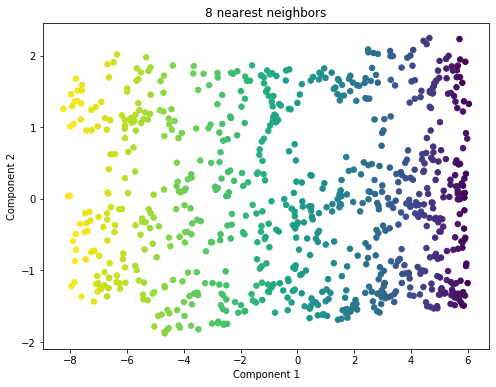

In [20]:
X = np.copy(Data)
X = StandardScaler().fit_transform(X)
X = Isomap_k(X, k)
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_title("8 nearest neighbors")
ax.scatter(X[-1], X[-2], s=30, c=t);

The improvement in relation to PCA is that the dataset is no longer just compressed down along one axis, but rolled out. 